# Final Model


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import cumfreq, beta

%matplotlib inline
plt.style.use('../notebook.mplstyle')

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw  
    Bm = 10
    Bw = 40
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    Um = lambda θ : θ 
    Uw = lambda θ : θ
    Fm = beta(2,2)
    Fw = beta(2,2)
    λm = 60
    λw = 10

## Two-Sided Search Equilibrium Conditions 


In [3]:
# Optimality conditions
def SSE(x): 
    # Endogenous Variables 
    μ = x[:Bm] 
    ω = x[Bm:Bm+Bw]   

    Pm = x[Bm+Bw:2*Bm+Bw]
    Pw = x[2*Bm+Bw:2*Bm+2*Bw]  

    Nm = x[2*Bm+2*Bw] 
    Nw = x[2*Bm+2*Bw+1]  
    
    τm = min(Nw/Nm, 1)
    τw = τm * (Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw)) 

    # Initialising system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2) 

    # Initial condition for men 
    E[0] = (Um(μ[0]) 
            - αm * Um(μ[0]) * Fw.cdf(μ[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), μ[0], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1, Bm):
        E[b] = (Um(μ[b]) 
                - αm * Um(μ[b]) * Fw.cdf(μ[b]) 
                - αm * Um(μ[b-1])*(1-Fw.cdf(μ[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), μ[b], μ[b-1])[0])
    
    # Initial condition for women     
    E[Bm] = (Uw(ω[0]) 
            - αw * Uw(ω[0]) * Fm.cdf(ω[0]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), ω[0], 1)[0])

    # Intertemporal optimality conditions for women
    for b in range(1, Bw):
        E[Bm+b] = (Uw(ω[b]) 
                - αw * Uw(ω[b]) * Fm.cdf(ω[b]) 
                - αw * Uw(ω[b-1])*(1-Fm.cdf(ω[b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), ω[b], ω[b-1])[0]) 
                
    # Platform flow men
    E[Bm+Bw] = λm - (1-δ)*Nm - Nm*Pm[0]*δ*τm*(1-Fw.cdf(μ[0]))

    for b in range(0, Bm-1):
       E[Bm+Bw+b+1] = (Nm*Pm[b+1]*δ*τm*(1-Fw.cdf(μ[b+1]))
                    - Nm*Pm[b]*(1-δ) - Nm*Pm[b]*δ*τm*(1-Fw.cdf(μ[b])))

    E[2*Bm+Bw] = λm - Nm*Pm[Bm-1]*(1-δ) - Nm*Pm[Bm-1]*δ*τm*(1-Fw.cdf(μ[Bm-1]))

    # Platform flow women
    E[2*Bm+Bw+1] = λw - (1-δ)*Nw - Nw*Pw[0]*δ*τw*(1-Fm.cdf(ω[0]))  

    for b in range(0, Bw-1):
       E[2*Bm+Bw+2+b] = (Nw*Pw[b+1]*δ*τw*(1-Fm.cdf(ω[b+1]))
                      - Nw*Pw[b]*(1-δ) - Nw*Pw[b]*δ*τw*(1-Fm.cdf(ω[b])))

    E[2*Bm+2*Bw+1] = λw - Nw*Pw[Bw-1]*(1-δ) - Nw*Pw[Bw-1]*δ*τw*(1-Fm.cdf(ω[Bw-1])) 

    return E 

## Solving For Steady State Equilibria 

In [4]:
reset_exog_params()
μ_test = np.random.rand(Bm) 
ω_test = np.random.rand(Bw) 

Pm_test = np.random.rand(Bm)
Pw_test = np.random.rand(Bw) 

N_test = np.array([λm*(Bm+1), λw*(Bw+1)])

print('μ0: ', μ_test)
print('ω0: ', ω_test)
print('')

x_start = np.concatenate((μ_test, ω_test, Pm_test, Pw_test, N_test), axis=None) 
solution = opt.root(SSE, x_start) 

μ0:  [0.28682448 0.01872371 0.17247723 0.72514624 0.01357756 0.5062676
 0.05260377 0.12207535 0.81225997 0.71012884]
ω0:  [0.1521767  0.83711659 0.316665   0.79794246 0.63159268 0.27551329
 0.56789581 0.79709848 0.36737214 0.59480439 0.19216811 0.51142602
 0.63847917 0.36450619 0.45928041 0.45211447 0.16261481 0.56372345
 0.78870324 0.35446363 0.83896461 0.94821597 0.44866038 0.0802758
 0.74556087 0.03933022 0.80038358 0.20128911 0.81687018 0.23195738
 0.06821982 0.65786341 0.04074485 0.40440288 0.28586291 0.63393263
 0.72291875 0.79159118 0.62528589 0.58662503]



In [5]:
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:Bm+Bw]
loss = round(np.sum(SSE(solution.x)**2), 3)
print('μ* ', μ_star) 
print('ω* ', ω_star) 
print('Loss: ',loss) 
print('')

Pm = solution.x[Bm+Bw:2*Bm+Bw]
Pw = solution.x[2*Bm+Bw:2*Bm+2*Bw]  

Nm = solution.x[2*Bm+2*Bw] 
Nw = solution.x[2*Bm+2*Bw+1]

# Normalized masses 
nm = [(Pm[b]*Nm)/(Nm+Nw) for b in range(Bm)]
nw = [(Pw[b]*Nw)/(Nm+Nw) for b in range(Bw)]

print('Masses: ', round((Nm)/(Nm+Nw),3), round((Nw)/(Nm+Nw),3))
print('Unity Sum check:', round(sum(Pm),3), round(sum(Pw),3))
print('')

τm = min(Nw/Nm, 1)
τw = τm * (Nm/Nw) 
αm = (τm*δ)/(1-δ*(1-τm))
αw = (τw*δ)/(1-δ*(1-τw)) 
print('Tightness: ', round(τm,3), round(τw,3))
print('Alphas: ', round(αm,3), round(αw,3)) 
print('')

ρm = sum([(1 - Fw.cdf(μ_star[b]))*Pm[b] for b in range(Bm)])
ρw = sum([(1 - Fm.cdf(ω_star[b]))*Pw[b] for b in range(Bw)])
print('Average Swipe Rate: ', round(ρm, 3), round(ρw, 3))

μ*  [0.49260515 0.37064112 0.29263991 0.23612645 0.19283216 0.15863423
 0.1311167  0.10871097 0.09032418 0.07515554]
ω*  [0.70533927 0.62995018 0.57829082 0.53802086 0.50467056 0.47605134
 0.45090913 0.42845071 0.40813879 0.38959062 0.37252281 0.3567189
 0.34200941 0.32825884 0.31535691 0.30321254 0.29174948 0.2809032
 0.2706185  0.26084777 0.25154957 0.24268761 0.23422989 0.226148
 0.21841659 0.21101296 0.20391663 0.19710909 0.19057351 0.18429456
 0.17825822 0.1724516  0.16686286 0.16148104 0.15629602 0.15129839
 0.14647941 0.14183093 0.13734531 0.13301544]
Loss:  0.0

Masses:  0.865 0.135
Unity Sum check: 1.0 1.0

Tightness:  0.156 1.0
Alphas:  0.835 0.97

Average Swipe Rate:  0.906 0.79


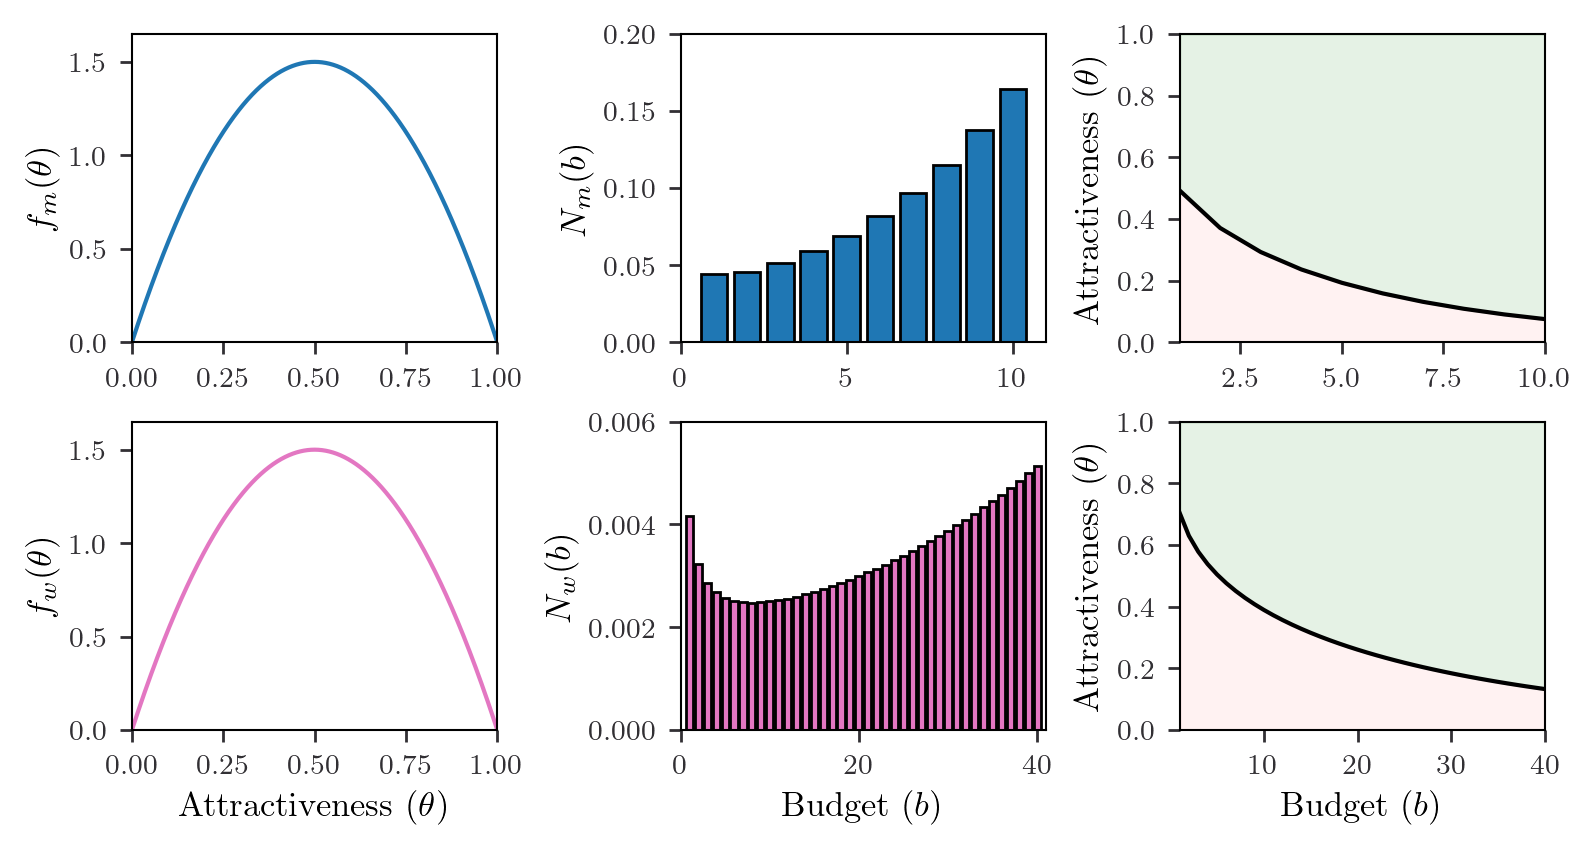

In [7]:
# Plotting Marginal PDFs
fig, axs = plt.subplots(2,3,figsize=(6.267704441677044, 3.2824362509300642), constrained_layout=True)
x = np.linspace(0, 1, 5000)

axs[0,0].set_xlim(0,1)
axs[0,0].set_ylim(0,1.1*max(Fm.pdf(x)))
axs[0,0].plot(x, Fm.pdf(x), color='tab:blue') 

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1.1*max(Fw.pdf(x)))
axs[1,0].plot(x, Fw.pdf(x), color='tab:pink')

# Plotting Marginal PMFs 
axs[0,1].set_xlim(0,Bm+1)
axs[0,1].bar(bm_vals, nm, color='tab:blue') 

axs[1,1].set_xlim(0,Bw+1)
axs[1,1].bar(bw_vals, nw, color='tab:pink') 

axs[0,1].set(ylabel=r'$N_m(b)$') 
axs[1,1].set(xlabel=r'Budget ($b$)', ylabel=r'$N_w(b)$') 

#axs[0,0].set_title('Men',loc='center')
axs[0,0].set(ylabel=r'$f_m(\theta)$')

#axs[0,1].set_title('Women',loc='center')
axs[1,0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'$f_w(\theta)$')


for i in range(2):
    B = Bm if i==0 else Bw
    b_vals = bm_vals if i==0 else bw_vals
    θ_vals = μ_star if i==0 else ω_star
    
    axs[i,2].set_xlim(1,B)
    axs[i,2].set_ylim(0,1)
    axs[i,2].plot(b_vals, θ_vals, color='k')
    axs[i,2].fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
    axs[i,2].fill_between(b_vals, θ_vals, 1, color='green', alpha=0.1)

axs[0,2].set(ylabel=r'Attractiveness ($\theta$)')
axs[1,2].set(xlabel=r'Budget ($b$)', ylabel=r'Attractiveness ($\theta$)') 
#plt.savefig('../../figures/mkt-cs-bdiff.png', bbox_inches='tight')
plt.show()